# Detecting Multilingual, Multicultural and Multievent Online Polarization

## Introduction

In this part of the starter notebook, we will take you through the process of all three Subtasks.

## Subtask 1 - Polarization detection

This is a binary classification to determine whether a post contains polarized content (Polarized or Not Polarized).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip '/content/drive/MyDrive/dev_phase.zip'

Archive:  /content/drive/MyDrive/dev_phase.zip
   creating: subtask1/
   creating: subtask1/dev/
  inflating: subtask1/dev/nep.csv    
  inflating: subtask1/dev/ita.csv    
  inflating: subtask1/dev/pol.csv    
  inflating: subtask1/dev/rus.csv    
  inflating: subtask1/dev/tel.csv    
  inflating: subtask1/dev/hin.csv    
  inflating: subtask1/dev/hau.csv    
  inflating: subtask1/dev/pan.csv    
  inflating: subtask1/dev/ori.csv    
  inflating: subtask1/dev/spa.csv    
  inflating: subtask1/dev/deu.csv    
  inflating: subtask1/dev/fas.csv    
  inflating: subtask1/dev/arb.csv    
  inflating: subtask1/dev/ben.csv    
  inflating: subtask1/dev/amh.csv    
  inflating: subtask1/dev/khm.csv    
  inflating: subtask1/dev/tur.csv    
  inflating: subtask1/dev/zho.csv    
  inflating: subtask1/dev/eng.csv    
  inflating: subtask1/dev/swa.csv    
  inflating: subtask1/dev/urd.csv    
  inflating: subtask1/dev/mya.csv    
   creating: subtask1/train/
  inflating: subtask1/train/nep.csv  


## Imports

In [3]:
import pandas as pd

from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.model_selection import train_test_split
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from torch.optim import AdamW

from collections import Counter
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
!pip install emoji
import emoji
import string
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 13.0 MB/s eta 0:00:00


In [4]:
import gc
from typing import Union, List, Dict
#from datasets import load_metric

In [5]:
import wandb

# Disable wandb logging for this script
wandb.init(mode="disabled")

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


## Data Import

The training data consists of a short text and binary labels

The data is structured as a CSV file with the following fields:
- id: a unique identifier for the sample
- text: a sentence or short text
- polarization:  1 text is polarized, 0 text is not polarized

The data is in all three subtask folders the same but only containing the labels for the specific task.

In [6]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

In [5]:
# Load the training and validation data for subtask 1
data_eng = pd.read_csv('subtask1/train/eng.csv')
test_eng = pd.read_csv('subtask1/dev/eng.csv')

data_swa = pd.read_csv('subtask1/train/swa.csv')
test_swa = pd.read_csv('subtask1/dev/swa.csv')

train_eng, val_eng = train_test_split(data_eng, test_size=0.2, random_state=42)
train_swa, val_swa = train_test_split(data_swa, test_size=0.2, random_state=42)

print("**"*25)
print(f"Total samples for english dataset: {len(data_eng)}")
print(f"Train samples: {len(train_eng)}")
print(f"Validation samples: {len(val_eng)}")


print("**"*25)
print(f"Total samples for swahili dataset: {len(data_swa)}")
print(f"Train samples: {len(train_swa)}")
print(f"Validation samples: {len(val_swa)}")



**************************************************
Total samples for english dataset: 3222
Train samples: 2577
Validation samples: 645
**************************************************
Total samples for swahili dataset: 6991
Train samples: 5592
Validation samples: 1399


In [9]:
train_eng.head()

,id,text,polarization
3000,eng_427cea503f2e3a2b4608d26fa87a55f0,The IDF needs some B52s.,0
366,eng_98eb4278a5fb9f249149a899b8f2c4e7,Fascinating life journey leads me to ANRAurora...,0
1965,eng_0d9c500e39edc99af8c61c45db8825a2,Lazy woke excuse to justify sjw practices,1
29,eng_69ebe50510087fb8c06cd12283a88ef8,5 takeaways on Republicans first impeachment h...,0
2689,eng_787ec0b4ddda46bbb5a0bf507a31d484,And yet Dems are supposed to be the breeders o...,1


In [10]:
test_eng.head()

,id,text,polarization
0,eng_f66ca14d60851371f9720aaf4ccd9b58,God is with Ukraine and Zelensky,NaN
1,eng_3a489aa7fed9726aa8d3d4fe74c57efb,"4 Dems, 2 Republicans Luzerne County Council s...",NaN
2,eng_95770ff547ea5e48b0be00f385986483,Abuse Survivor Recounts Her Struggles at YWCA ...,NaN
3,eng_2048ae6f9aa261c48e6d777bcc5b38bf,"After Rwanda, another deportation camp disaster",NaN
4,eng_07781aa88e61e7c0a996abd1e5ea3a20,Another plea in Trump election interference probe,NaN


In [11]:
train_swa.head()

,id,text,polarization
3875,swa_1e08a561fc1d7881fffb4822639b357f,kenya iuzw mtu apew share yake ama waturudishi...,0
1768,swa_b436d75df7d5cc4847f2c973740e49d0,bana rt mamzee especially hawa hapa twitter rt...,1
3250,swa_71b7ef26027e30d7f0e3025b5afb45ff,uliwaibia nani hao majembe la kutombwa pussy m...,0
6574,swa_fb121178c35ba35b1fafc735704824fa,Woi Museveni will kill us hio kamba hata ya ba...,1
2815,swa_1352a5d0c27ff8f79314abf4597a5046,mt hulipwa na supremacist mweupe kila wakati h...,0


In [12]:
test_swa.head()

,id,text,polarization
0,swa_a5748df181277341143f7da4175add4a,walai iyo nyapati haijanifurahisha ata hawa wa...,NaN
1,swa_2df0d42f9b49ea2e4fb006b2e6604e6d,wajaluo maumbwa kabla utaje jina kubwa uhuru a...,NaN
2,swa_3718757514005767302b7220b08e409d,wakale wanafuatana na hawa wakikuyu mbna,NaN
3,swa_9fa3337a35cce723d60c06056d422330,wakikuyu wadeportiwe pia warudi kwao waruitania,NaN
4,swa_5c39ac8ef70345e9e3c21a47f8769bc0,wajaluo mnajionanga magenious sana,NaN


# Exploratory Data Analysis

## Polarisation Class Distribution

/tmp/ipython-input-3697959139.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=eng_counts.index, y=eng_counts.values, palette=['skyblue', 'salmon'])


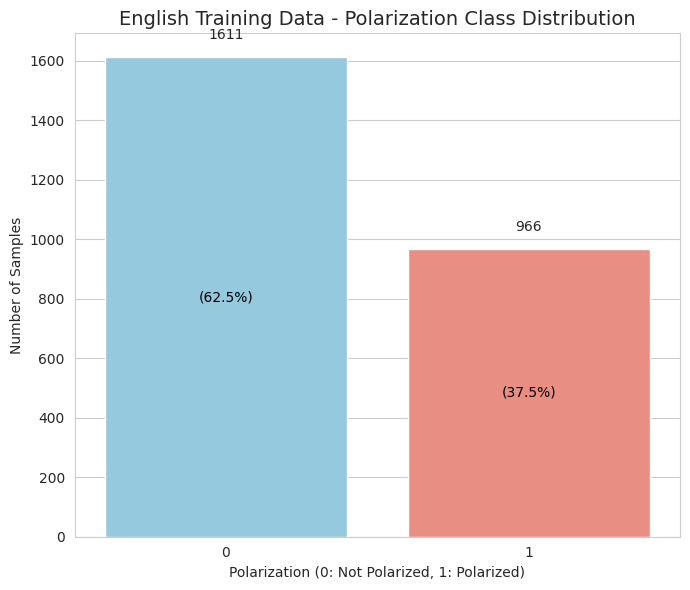

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# English Dataset Plot
plt.figure(figsize=(7, 6))
eng_counts = train_eng['polarization'].value_counts()
ax = sns.barplot(x=eng_counts.index, y=eng_counts.values, palette=['skyblue', 'salmon'])

plt.title('English Training Data - Polarization Class Distribution', fontsize=14)
plt.xlabel('Polarization (0: Not Polarized, 1: Polarized)')
plt.ylabel('Number of Samples')

# Add counts and percentages
for i, count in enumerate(eng_counts.values):
    ax.text(i, count + 50, str(count), ha='center', va='bottom', fontsize=10)
    percent = f'({count / len(train_eng) * 100:.1f}%)'
    ax.text(i, count/2, percent, ha='center', va='center', color='black', fontsize=10)

plt.tight_layout()
plt.savefig('english_polarization_distribution.pdf', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipython-input-214373522.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=swa_counts.index, y=swa_counts.values, palette=['skyblue', 'salmon'])


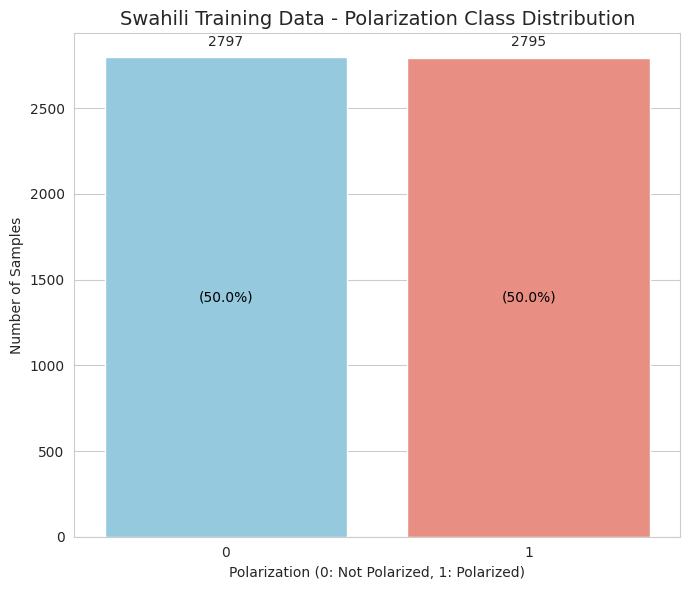

In [8]:
# Swahili Dataset Plot
plt.figure(figsize=(7, 6))
swa_counts = train_swa['polarization'].value_counts()
ax = sns.barplot(x=swa_counts.index, y=swa_counts.values, palette=['skyblue', 'salmon'])

plt.title('Swahili Training Data - Polarization Class Distribution', fontsize=14)
plt.xlabel('Polarization (0: Not Polarized, 1: Polarized)')
plt.ylabel('Number of Samples')

# Add counts and percentages
for i, count in enumerate(swa_counts.values):
    ax.text(i, count + 50, str(count), ha='center', va='bottom', fontsize=10)
    percent = f'({count / len(train_swa) * 100:.1f}%)'
    ax.text(i, count/2, percent, ha='center', va='center', color='black', fontsize=10)

plt.tight_layout()
plt.savefig('swahili_polarization_distribution.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Set plotting style
# sns.set_style("whitegrid")
# # Create a figure with two subplots side-by-side
# fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# fig.suptitle('Polarization Class Distribution', fontsize=16)

# # --- English Dataset ---
# eng_counts = train_eng['polarization'].value_counts()
# sns.barplot(x=eng_counts.index, y=eng_counts.values, ax=axes[0], palette=['skyblue', 'salmon'])
# axes[0].set_title('English Training Data')
# axes[0].set_xlabel('Polarization (0: Not Polarized, 1: Polarized)')
# axes[0].set_ylabel('Number of Samples')
# for i, count in enumerate(eng_counts.values):
#     axes[0].text(i, count + 50, str(count), ha='center', va='bottom', fontsize=10)
#     percent = f'({count / len(train_eng) * 100:.1f}%)'
#     axes[0].text(i, count/2, percent, ha='center', va='center', color='black', fontsize=10)

# # --- Swahili Dataset ---
# swa_counts = train_swa['polarization'].value_counts()
# sns.barplot(x=swa_counts.index, y=swa_counts.values, ax=axes[1], palette=['skyblue', 'salmon'])
# axes[1].set_title('Swahili Training Data')
# axes[1].set_xlabel('Polarization (0: Not Polarized, 1: Polarized)')
# axes[1].set_ylabel('Number of Samples')
# for i, count in enumerate(swa_counts.values):
#     axes[1].text(i, count + 50, str(count), ha='center', va='bottom', fontsize=10)
#     percent = f'({count / len(train_swa) * 100:.1f}%)'
#     axes[1].text(i, count/2, percent, ha='center', va='center', color='black', fontsize=10)

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.savefig('polarization_class_distribution.pdf', dpi=300, bbox_inches='tight')
# plt.show()

## Distribution of Text lengths

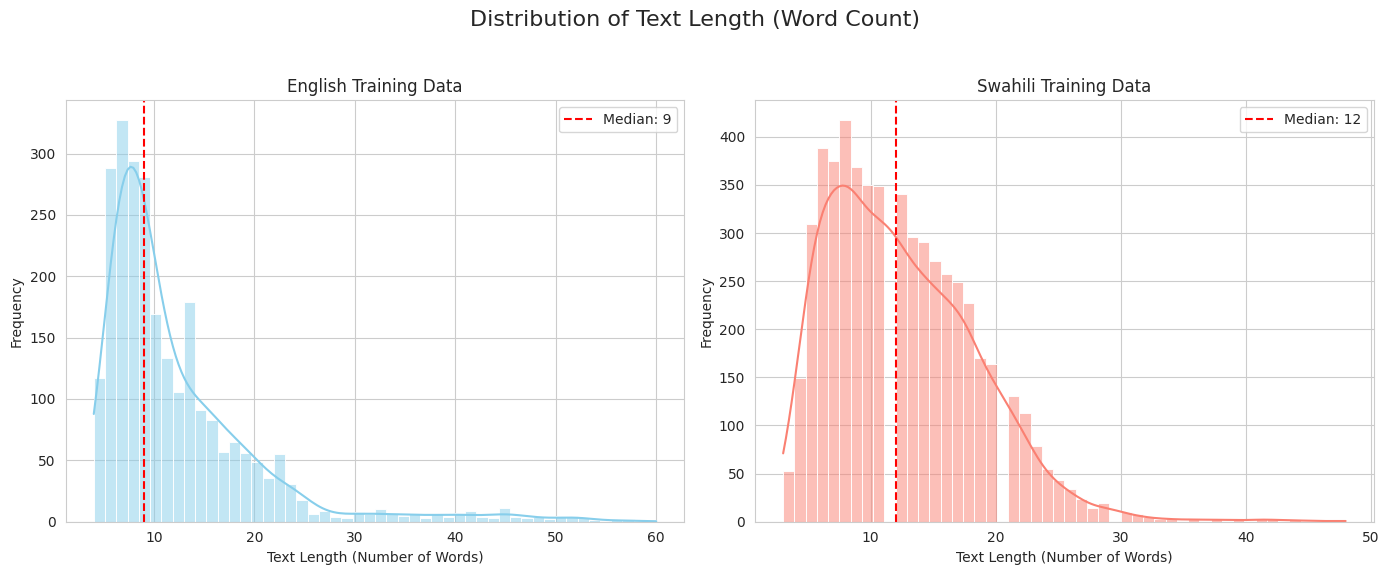


--- Summary Statistics for Text Length ---
English:
 count    2577.000000
mean       12.371750
std         8.172059
min         4.000000
50%         9.000000
75%        15.000000
90%        21.000000
95%        27.000000
max        60.000000
Name: text_length, dtype: float64

Swahili:
 count    5592.000000
mean       12.544886
std         6.034669
min         3.000000
50%        12.000000
75%        16.000000
90%        21.000000
95%        23.000000
max        48.000000
Name: text_length, dtype: float64


In [14]:
# Function to calculate word length
def calculate_text_length(df):
    # Count the number of words (tokens) in the text
    df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))
    return df

# Calculate lengths for all datasets
train_eng = calculate_text_length(train_eng)
train_swa = calculate_text_length(train_swa)

# Create a figure with two subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Distribution of Text Length (Word Count)', fontsize=16)

# --- English Dataset ---
sns.histplot(train_eng['text_length'], bins=50, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('English Training Data')
axes[0].set_xlabel('Text Length (Number of Words)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(train_eng['text_length'].median(), color='red', linestyle='--', label=f'Median: {train_eng["text_length"].median():.0f}')
axes[0].legend()

# --- Swahili Dataset ---
sns.histplot(train_swa['text_length'], bins=50, kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Swahili Training Data')
axes[1].set_xlabel('Text Length (Number of Words)')
axes[1].set_ylabel('Frequency')
axes[1].axvline(train_swa['text_length'].median(), color='red', linestyle='--', label=f'Median: {train_swa["text_length"].median():.0f}')
axes[1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('text_length_distribution.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Display summary statistics to help choose max_len
print("\n--- Summary Statistics for Text Length ---")
print("English:\n", train_eng['text_length'].describe(percentiles=[.5, .75, .9, .95]))
print("\nSwahili:\n", train_swa['text_length'].describe(percentiles=[.5, .75, .9, .95]))

## Most prominent words

/tmp/ipython-input-4127965154.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=df_eng, palette='viridis')


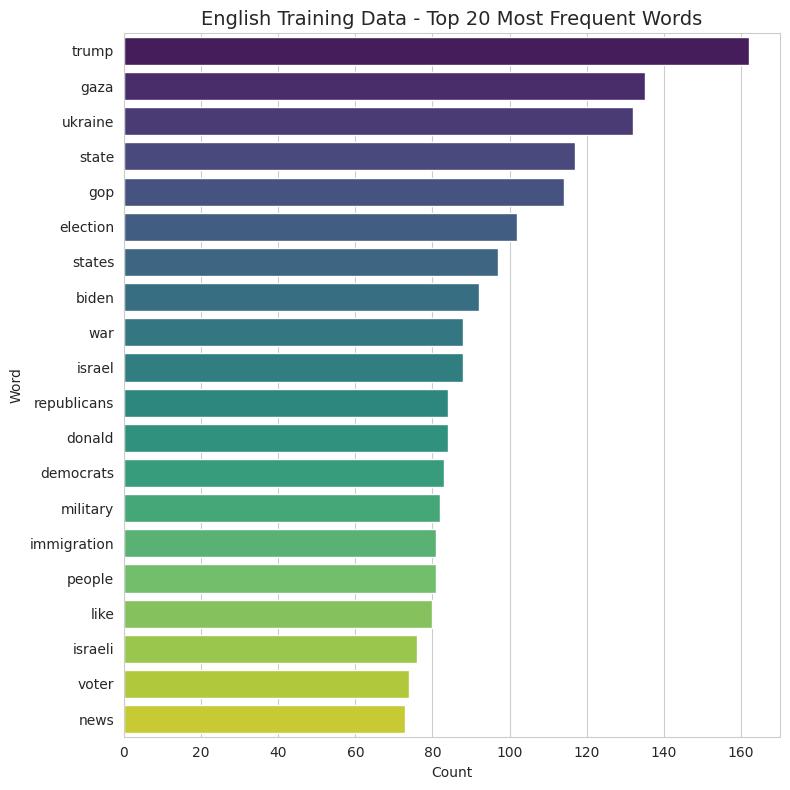

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from nltk.corpus import stopwords

# Ensure stopwords are downloaded
# import nltk
# nltk.download('stopwords')

def get_top_n_words(corpus, n=None, language='english'):
    """Extracts top N words from a list of texts after tokenization and stop word removal."""
    if language == 'english':
        stop_words = set(stopwords.words('english'))
    else:
        # Fallback/Custom list for Swahili if nltk not used
        stop_words = {'na', 'katika', 'wa', 'ya', 'ni', 'kwa', 'kuwa', 'hiyo', 'kwenye', 'hayo'}

    words = []
    for text in corpus:
        text = str(text).lower()
        tokens = re.findall(r'\b\w+\b', text)
        words.extend([word for word in tokens if word not in stop_words and len(word) > 2])

    return Counter(words).most_common(n)

# --- English Dataset Plot ---
plt.figure(figsize=(8, 8))
top_eng_words = get_top_n_words(train_eng['text'], n=20, language='english')
df_eng = pd.DataFrame(top_eng_words, columns=['Word', 'Count'])

sns.barplot(x='Count', y='Word', data=df_eng, palette='viridis')
plt.title('English Training Data - Top 20 Most Frequent Words', fontsize=14)
plt.xlabel('Count')
plt.ylabel('Word')

plt.tight_layout()
plt.savefig('english_top_words.pdf', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipython-input-3595379298.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=df_swa, palette='plasma')


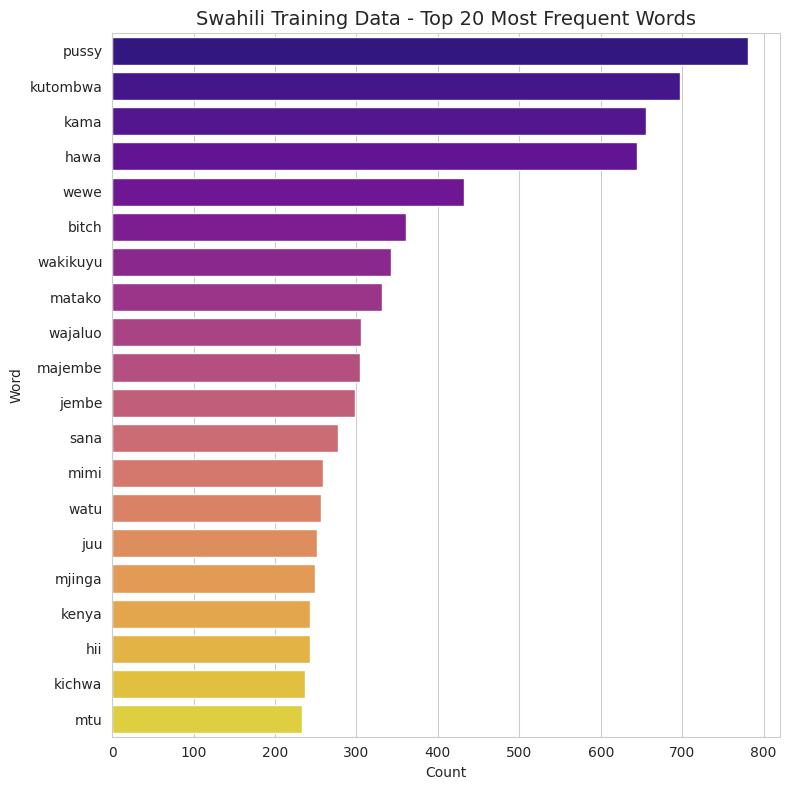

In [10]:
# --- Swahili Dataset Plot ---
# (Assuming get_top_n_words function is already defined as above)

plt.figure(figsize=(8, 8))
top_swa_words = get_top_n_words(train_swa['text'], n=20, language='swahili')
df_swa = pd.DataFrame(top_swa_words, columns=['Word', 'Count'])

sns.barplot(x='Count', y='Word', data=df_swa, palette='plasma')
plt.title('Swahili Training Data - Top 20 Most Frequent Words', fontsize=14)
plt.xlabel('Count')
plt.ylabel('Word')

plt.tight_layout()
plt.savefig('swahili_top_words.pdf', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipython-input-3417906917.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=df_eng, ax=axes[0], palette='viridis')
/tmp/ipython-input-3417906917.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=df_swa, ax=axes[1], palette='plasma')


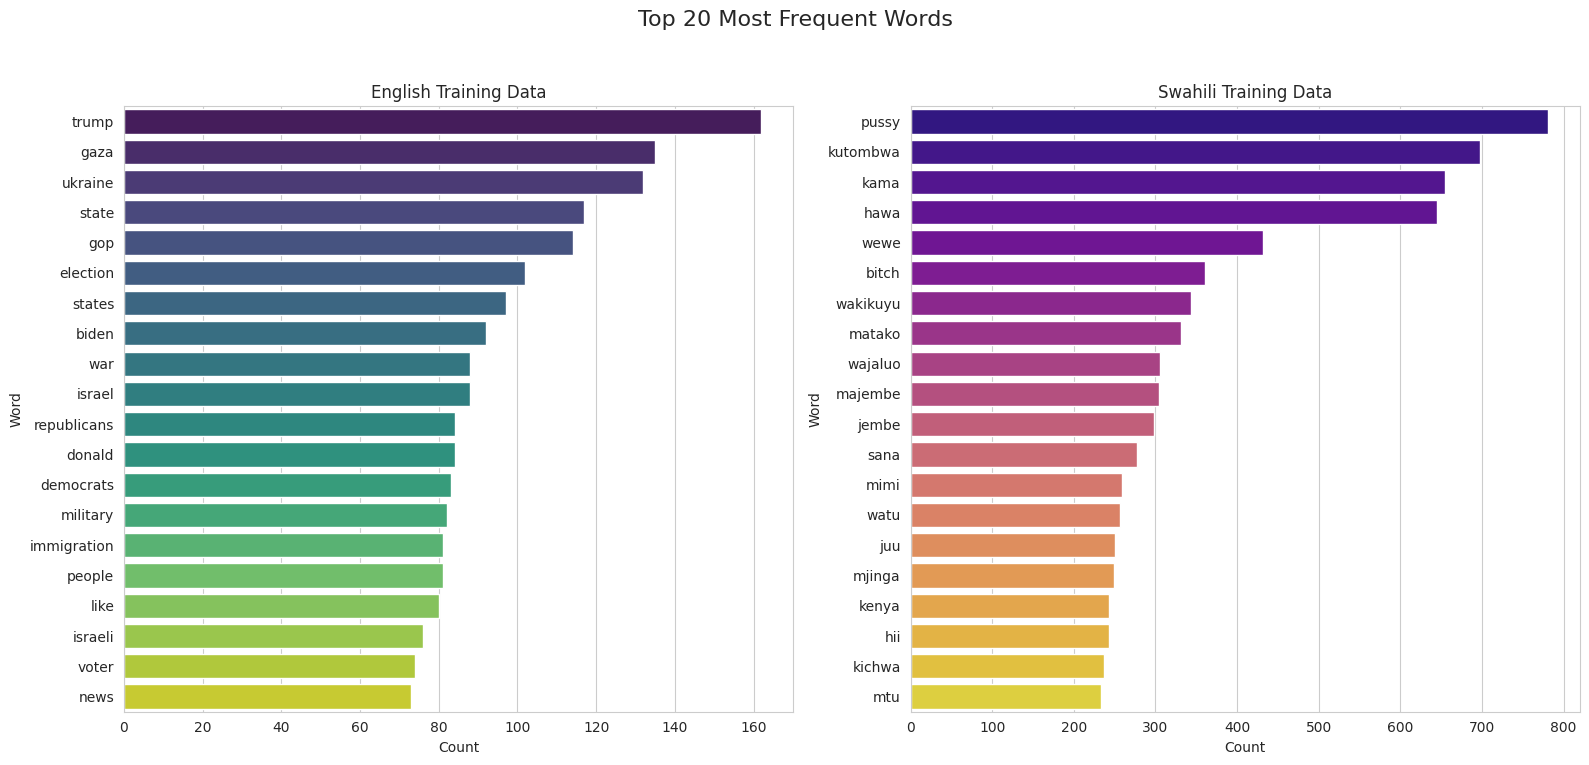

In [15]:
def get_top_n_words(corpus, n=None, language='english'):
    """Extracts top N words from a list of texts after tokenization and stop word removal."""

    if language == 'english':
        stop_words = set(stopwords.words('english'))
    else:
        stop_words = {'na', 'katika', 'wa', 'ya', 'ni', 'kwa', 'kuwa', 'hiyo', 'kwenye', 'hayo'}

    words = []
    for text in corpus:
        text = str(text).lower()
        tokens = re.findall(r'\b\w+\b', text)
        words.extend([word for word in tokens if word not in stop_words and len(word) > 2])

    return Counter(words).most_common(n)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Top 20 Most Frequent Words', fontsize=16)

# English Dataset
top_eng_words = get_top_n_words(train_eng['text'], n=20, language='english')
df_eng = pd.DataFrame(top_eng_words, columns=['Word', 'Count'])
sns.barplot(x='Count', y='Word', data=df_eng, ax=axes[0], palette='viridis')
axes[0].set_title('English Training Data')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Word')

# Swahili Dataset
top_swa_words = get_top_n_words(train_swa['text'], n=20, language='swahili')
df_swa = pd.DataFrame(top_swa_words, columns=['Word', 'Count'])
sns.barplot(x='Count', y='Word', data=df_swa, ax=axes[1], palette='plasma')
axes[1].set_title('Swahili Training Data')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Word')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('top_words.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Text cleaning and normalization

## Strategy 1: Emojis to text

In [31]:
# Define the cleaning functions
def clean_text_strategy_1(text):
    """
    Cleaning Strategy 1: Remove URLs/Users, Convert Emojis to Text.
    This preserves the emotional weight of the emoji as a word.
    """
    text = str(text)

    # URL Removal
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # 2. @user Removal
    text = re.sub(r'@\w+', '', text)

    # Emoji to Text Conversion
    text = emoji.demojize(text, delimiters=(" ", " "))
    text = ' '.join(text.split())

    return text

## Strategy 2: Emojis deletion

In [32]:
def clean_text_strategy_2(text):
    """
    Cleaning Strategy 2: Remove URLs/Users, Remove Emojis Entirely.
    This offers a cleaner, more concise text representation.
    """
    text = str(text)

    # 1. URL Removal
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # 2. @user Removal
    text = re.sub(r'@\w+', '', text)

    # 3. Emoji Removal
    text = emoji.replace_emoji(text, replace='')
    text = ' '.join(text.split())

    return text

# Subtask 1: Polarization detection

# Dataset
-  Create a pytorch class for handling data
-  Wrapping the raw texts and labels into a format that Huggingface’s Trainer can use for training and evaluation

In [8]:
# Dataset class for polarization detection
class PolarizationDataset(torch.utils.data.Dataset):
    def __init__(self, texts, tokenizer, labels=None, max_length=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding=False,
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Ensure consistent tensor conversion for all items
        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        if self.labels is not None:
            label = self.labels[idx]
            item['labels'] = torch.tensor(label, dtype=torch.long)
        return item

In [9]:
# Define the F1 Macro metric function
def compute_metrics(p):
    """Computes Macro F1 score for binary classification."""
    preds = np.argmax(p.predictions, axis=1)
    macro_f1 = f1_score(p.label_ids, preds, average='macro')
    return {'f1_macro': macro_f1}

In [10]:
# Clear GPU memory upfront
gc.collect()
torch.cuda.empty_cache()

# Different Models

# Strategy 0: No Data Cleaning

# Strategy 1: Emojis to text

In [33]:
for df in [train_eng, val_eng, train_swa, val_swa]:
    df['text_cleaned'] = df['text'].apply(clean_text_strategy_1)


test_eng['text_cleaned'] = test_eng['text'].apply(clean_text_strategy_1)
test_swa['text_cleaned'] = test_swa['text'].apply(clean_text_strategy_1)

# Strategy 2: Deletion of Emojis

In [12]:
for df in [train_eng, val_eng, train_swa, val_swa]:
    df['text_cleaned_s2'] = df['text'].apply(clean_text_strategy_2)

print("Applying Strategy 2 (Emoji Deletion) to Test data...")
test_eng['text_cleaned_s2'] = test_eng['text'].apply(clean_text_strategy_2)
test_swa['text_cleaned_s2'] = test_swa['text'].apply(clean_text_strategy_2)

Applying Strategy 2 (Emoji Deletion) to Test data...


Now, we'll tokenize the text data and create the datasets using different models as the tokenizer.

## XLM-RoBERTa

In [11]:
MODEL_XLM_R = "xlm-roberta-base"

# Load the tokenizer
tokenizer_xlm_r = AutoTokenizer.from_pretrained(MODEL_XLM_R)

# Create datasets for English
train_dataset_eng_xlm_r = PolarizationDataset(
    train_eng['text'].tolist(),
    tokenizer_xlm_r,
    train_eng['polarization'].tolist()
)
val_dataset_eng_xlm_r = PolarizationDataset(
    val_eng['text'].tolist(),
    tokenizer_xlm_r,
    val_eng['polarization'].tolist()
)
test_dataset_eng_xlm_r = PolarizationDataset(test_eng['text'].tolist(), tokenizer=tokenizer_xlm_r)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [12]:
# Create datasets for Swahili
train_dataset_swa_xlm_r = PolarizationDataset(
    train_swa['text'].tolist(),
    tokenizer_xlm_r,
    train_swa['polarization'].tolist()
)
val_dataset_swa_xlm_r = PolarizationDataset(
    val_swa['text'].tolist(),
    tokenizer_xlm_r,
    val_swa['polarization'].tolist()
)
test_dataset_swa_xlm_r = PolarizationDataset(test_swa['text'].tolist(), tokenizer_xlm_r)

In [13]:
# Load the model
model_xlm_r = AutoModelForSequenceClassification.from_pretrained(MODEL_XLM_R, num_labels=2)
print(f"Loaded XLM-RoBERTa Model: {MODEL_XLM_R}")

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded XLM-RoBERTa Model: xlm-roberta-base


## RoBERTa + DistilBERT

In [14]:
# RoBERTa
MODEL_ROBERTA = "roberta-base"
tokenizer_roberta = AutoTokenizer.from_pretrained(MODEL_ROBERTA)

# Create datasets for English
train_dataset_eng_roberta = PolarizationDataset(
    train_eng['text'].tolist(),
    tokenizer_roberta,
    train_eng['polarization'].tolist()
)
val_dataset_eng_roberta = PolarizationDataset(
    val_eng['text'].tolist(),
    tokenizer_roberta,
    val_eng['polarization'].tolist()
)
test_dataset_eng_roberta = PolarizationDataset(test_eng['text'].tolist(), tokenizer_roberta)

# Load Model
model_roberta = AutoModelForSequenceClassification.from_pretrained(MODEL_ROBERTA, num_labels=2)
print(f"Loaded RoBERTa Model: {MODEL_ROBERTA}")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded RoBERTa Model: roberta-base


In [15]:
# DistilRoBERTa
MODEL_DISTILROBERTA = "distilroberta-base"
tokenizer_distilroberta = AutoTokenizer.from_pretrained(MODEL_DISTILROBERTA)

# Create datasets for English
train_dataset_eng_distilroberta = PolarizationDataset(
    train_eng['text'].tolist(),
    tokenizer_distilroberta,
    train_eng['polarization'].tolist()
)
val_dataset_eng_distilroberta = PolarizationDataset(
    val_eng['text'].tolist(),
    tokenizer_distilroberta,
    val_eng['polarization'].tolist()
)
test_dataset_eng_distilroberta = PolarizationDataset(test_eng['text'].tolist(), tokenizer_distilroberta)

# Load model
model_distilroberta = AutoModelForSequenceClassification.from_pretrained(MODEL_DISTILROBERTA, num_labels=2)
print(f"Loaded DistilRoBERTa Model: {MODEL_DISTILROBERTA}")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded DistilRoBERTa Model: distilroberta-base


## Afro-XLM-R, AfriBERTa and SwahBERT

In [16]:
# Afro-XLM-R
MODEL_AFRO_XLMR = "Davlan/afro-xlmr-large"
tokenizer_afro_xlmr = AutoTokenizer.from_pretrained(MODEL_AFRO_XLMR)

# Create datasets for Swahili
train_dataset_swa_afro_xlm_r = PolarizationDataset(
    train_swa['text'].tolist(),
    tokenizer_afro_xlmr,
    train_swa['polarization'].tolist()
)
val_dataset_swa_afro_xlm_r = PolarizationDataset(
    val_swa['text'].tolist(),
    tokenizer_afro_xlmr,
    val_swa['polarization'].tolist()
)
test_dataset_swa_afro_xlm_r = PolarizationDataset(test_swa['text'].tolist(), tokenizer_afro_xlmr)

# Load Model
model_afro_xlmr = AutoModelForSequenceClassification.from_pretrained(MODEL_AFRO_XLMR, num_labels=2)
print(f"Loaded Afro-XLM-R Model: {MODEL_AFRO_XLMR}")


tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/714 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded Afro-XLM-R Model: Davlan/afro-xlmr-large


In [17]:
# SwahBERT
MODEL_SWAHBERT = "metabloit/swahBERT"
tokenizer_swahbert = AutoTokenizer.from_pretrained(MODEL_SWAHBERT)

# Create datasets for Swahili
train_dataset_swa_swahbert = PolarizationDataset(
    train_swa['text'].tolist(),
    tokenizer_swahbert,
    train_swa['polarization'].tolist()
)
val_dataset_swa_swahbert = PolarizationDataset(
    val_swa['text'].tolist(),
    tokenizer_swahbert,
    val_swa['polarization'].tolist()
)
test_dataset_swa_swahbert = PolarizationDataset(test_swa['text'].tolist(), tokenizer_swahbert)

# Load Model
model_swahbert = AutoModelForSequenceClassification.from_pretrained(MODEL_SWAHBERT, num_labels=2)
print(f"Loaded SwahBERT Model: {MODEL_SWAHBERT}")

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Invalid model-index. Not loading eval results into CardData.


model.safetensors:   0%|          | 0.00/498M [00:01<?, ?B/s]

Loaded SwahBERT Model: metabloit/swahBERT


In [18]:
# AfriBERTa
MODEL_AFRIBERTA = "castorini/afriberta_large"
tokenizer_afriberta = AutoTokenizer.from_pretrained(MODEL_AFRIBERTA)

# Create datasets for Swahili
train_dataset_swa_afriberta = PolarizationDataset(
    train_swa['text'].tolist(),
    tokenizer_afriberta,
    train_swa['polarization'].tolist()
)
val_dataset_swa_afriberta = PolarizationDataset(
    val_swa['text'].tolist(),
    tokenizer_afriberta,
    val_swa['polarization'].tolist()
)
test_dataset_swa_afriberta = PolarizationDataset(test_swa['text'].tolist(), tokenizer_afriberta)

# Load Model
model_afriberta = AutoModelForSequenceClassification.from_pretrained(MODEL_AFRIBERTA, num_labels=2)
print(f"Loaded AfriBERTa Model: {MODEL_AFRIBERTA}")

tokenizer_config.json:   0%|          | 0.00/257 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.55M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/503M [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at castorini/afriberta_large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded AfriBERTa Model: castorini/afriberta_large


## The training Pipeline

In [19]:
# Training Pipeline Function
def run_training_pipeline(
    model: AutoModelForSequenceClassification,
    tokenizer: AutoTokenizer,
    train_dataset: torch.utils.data.Dataset,
    val_dataset: torch.utils.data.Dataset,
    test_dataset: torch.utils.data.Dataset,
    test_df: pd.DataFrame,
    model_name_short: str,
    language_code: str
):
    """
    Sets up training arguments, initializes the Trainer, runs training/evaluation,
    and generates the final submission file for a single model configuration.
    """

    output_dir = f"./results/{model_name_short}_{language_code}_subtask1"

    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=3,
        learning_rate=2e-5,
        per_device_train_batch_size=64,
        per_device_eval_batch_size=64,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=False,
        logging_steps=50,
        disable_tqdm=False,
        report_to="none"
    )

    # Training Environment
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Initialize the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    )

    print(f"\n{'='*50}")
    print(f"Starting Training: {model_name_short} ({language_code})")
    print(f"{'='*50}")

    # Train the model
    trainer.train()

    # Evaluate the model on the validation set
    print(f"\nEvaluating {model_name_short} on Validation Set...")
    eval_results = trainer.evaluate()
    print(f"Macro F1 score on validation set: {eval_results['eval_f1_macro']:.4f}")

    # Generate predictions and submission file
    print(f"\nGenerating predictions on the test set for {language_code}...")

    raw_predictions = trainer.predict(test_dataset)

    logits = raw_predictions.predictions
    predictions = np.argmax(logits, axis=1)

    submission_df = pd.DataFrame({
        'id': test_df['id'],
        'polarization': predictions
    })

    output_filename = f"pred_subtask1_{model_name_short}_{language_code}.csv"

    submission_df.to_csv(output_filename, index=False)

    print(f"\nSubmission file saved successfully as: {output_filename}")
    print("First 5 rows of the submission file:")
    print(submission_df.head().to_markdown(index=False))

    return eval_results['eval_f1_macro']

## Execution of the pipeline

In [20]:
all_results = {}

## Multilingual Model

In [21]:
# English with XLM-RoBERTa
f1_eng_xlm_r = run_training_pipeline(
    model=model_xlm_r,
    tokenizer=tokenizer_xlm_r,
    train_dataset=train_dataset_eng_xlm_r,
    val_dataset=val_dataset_eng_xlm_r,
    test_dataset=test_dataset_eng_xlm_r, # Needs to be defined
    test_df=test_eng, # Needs to be defined
    model_name_short="XLM-R",
    language_code="eng"
)
all_results["XLM-R_eng"] = f1_eng_xlm_r


Starting Training: XLM-R (eng)


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.491634,0.686833
2,0.599900,0.457434,0.744677
3,0.485400,0.460341,0.754055



Evaluating XLM-R on Validation Set...


Macro F1 score on validation set: 0.7541

Generating predictions on the test set for eng...

Submission file saved successfully as: pred_subtask1_XLM-R_eng.csv
First 5 rows of the submission file:
| id                                   |   polarization |
|:-------------------------------------|---------------:|
| eng_f66ca14d60851371f9720aaf4ccd9b58 |              0 |
| eng_3a489aa7fed9726aa8d3d4fe74c57efb |              0 |
| eng_95770ff547ea5e48b0be00f385986483 |              0 |
| eng_2048ae6f9aa261c48e6d777bcc5b38bf |              0 |
| eng_07781aa88e61e7c0a996abd1e5ea3a20 |              0 |


In [22]:
# Swahili with XLM-RoBERTa
f1_swa_xlm_r = run_training_pipeline(
    model=model_xlm_r,
    tokenizer=tokenizer_xlm_r,
    train_dataset=train_dataset_swa_xlm_r,
    val_dataset=val_dataset_swa_xlm_r,
    test_dataset=test_dataset_swa_xlm_r, # Needs to be defined
    test_df=test_swa, # Needs to be defined
    model_name_short="XLM-R",
    language_code="swa"
)
all_results["XLM-R_swa"] = f1_swa_xlm_r


Starting Training: XLM-R (swa)


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.608800,0.477638,0.777436
2,0.488400,0.464885,0.786255
3,0.445200,0.451857,0.793287



Evaluating XLM-R on Validation Set...


Macro F1 score on validation set: 0.7933

Generating predictions on the test set for swa...

Submission file saved successfully as: pred_subtask1_XLM-R_swa.csv
First 5 rows of the submission file:
| id                                   |   polarization |
|:-------------------------------------|---------------:|
| swa_a5748df181277341143f7da4175add4a |              1 |
| swa_2df0d42f9b49ea2e4fb006b2e6604e6d |              1 |
| swa_3718757514005767302b7220b08e409d |              1 |
| swa_9fa3337a35cce723d60c06056d422330 |              1 |
| swa_5c39ac8ef70345e9e3c21a47f8769bc0 |              1 |


## English Monolingual/Distilled Models

In [37]:
# English with RoBERTa
f1_eng_roberta = run_training_pipeline(
    model=model_roberta,
    tokenizer=tokenizer_roberta,
    train_dataset=train_dataset_eng_roberta,
    val_dataset=val_dataset_eng_roberta,
    test_dataset=test_dataset_eng_roberta,
    test_df=test_eng,
    model_name_short="RoBERTa",
    language_code="eng"
)
all_results["RoBERTa_eng"] = f1_eng_roberta


Starting Training: RoBERTa (eng)


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.465879,0.740556
2,0.579000,0.435201,0.778478
3,0.422800,0.445242,0.790762



Evaluating RoBERTa on Validation Set...


Macro F1 score on validation set: 0.7908

Generating predictions on the test set for eng...

Submission file saved successfully as: pred_subtask1_RoBERTa_eng.csv
First 5 rows of the submission file:
| id                                   |   polarization |
|:-------------------------------------|---------------:|
| eng_f66ca14d60851371f9720aaf4ccd9b58 |              0 |
| eng_3a489aa7fed9726aa8d3d4fe74c57efb |              0 |
| eng_95770ff547ea5e48b0be00f385986483 |              0 |
| eng_2048ae6f9aa261c48e6d777bcc5b38bf |              0 |
| eng_07781aa88e61e7c0a996abd1e5ea3a20 |              0 |


In [23]:
# English with DistilRoBERTa
f1_eng_distilroberta = run_training_pipeline(
    model=model_distilroberta,
    tokenizer=tokenizer_distilroberta,
    train_dataset=train_dataset_eng_distilroberta,
    val_dataset=val_dataset_eng_distilroberta,
    test_dataset=test_dataset_eng_distilroberta,
    test_df=test_eng,
    model_name_short="DistilRoBERTa",
    language_code="eng"
)
all_results["DistilRoBERTa_eng"] = f1_eng_distilroberta


Starting Training: DistilRoBERTa (eng)


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.464046,0.732396
2,0.547400,0.436258,0.768412
3,0.410700,0.434630,0.778251



Evaluating DistilRoBERTa on Validation Set...


Macro F1 score on validation set: 0.7783

Generating predictions on the test set for eng...

Submission file saved successfully as: pred_subtask1_DistilRoBERTa_eng.csv
First 5 rows of the submission file:
| id                                   |   polarization |
|:-------------------------------------|---------------:|
| eng_f66ca14d60851371f9720aaf4ccd9b58 |              0 |
| eng_3a489aa7fed9726aa8d3d4fe74c57efb |              0 |
| eng_95770ff547ea5e48b0be00f385986483 |              0 |
| eng_2048ae6f9aa261c48e6d777bcc5b38bf |              0 |
| eng_07781aa88e61e7c0a996abd1e5ea3a20 |              0 |


## Swahili Domain-Specific Models

In [18]:
# Clear GPU memory upfront
gc.collect()
torch.cuda.empty_cache()

# Swahili with Afro-XLM-R
f1_swa_afro_xlmr = run_training_pipeline(
    model=model_afro_xlmr,
    tokenizer=tokenizer_afro_xlmr,
    train_dataset=train_dataset_swa_afro_xlm_r,
    val_dataset=val_dataset_swa_afro_xlm_r,
    test_dataset=test_dataset_swa_afro_xlm_r,
    test_df=test_swa,
    model_name_short="Afro-XLM-R",
    language_code="swa"
)
all_results["Afro-XLM-R_swa"] = f1_swa_afro_xlmr


Starting Training: Afro-XLM-R (swa)


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.728700,0.550546,0.687053
2,0.483500,0.448372,0.791016
3,0.411300,0.420101,0.791279



Evaluating Afro-XLM-R on Validation Set...


Macro F1 score on validation set: 0.7913

Generating predictions on the test set for swa...

Submission file saved successfully as: pred_subtask1_Afro-XLM-R_swa.csv
First 5 rows of the submission file:
| id                                   |   polarization |
|:-------------------------------------|---------------:|
| swa_a5748df181277341143f7da4175add4a |              1 |
| swa_2df0d42f9b49ea2e4fb006b2e6604e6d |              1 |
| swa_3718757514005767302b7220b08e409d |              1 |
| swa_9fa3337a35cce723d60c06056d422330 |              1 |
| swa_5c39ac8ef70345e9e3c21a47f8769bc0 |              1 |


In [19]:
# Clear GPU memory upfront
gc.collect()
torch.cuda.empty_cache()

# Swahili with SwahBERT
f1_swa_swahbert = run_training_pipeline(
    model=model_swahbert,
    tokenizer=tokenizer_swahbert,
    train_dataset=train_dataset_swa_swahbert,
    val_dataset=val_dataset_swa_swahbert,
    test_dataset=test_dataset_swa_swahbert,
    test_df=test_swa,
    model_name_short="SwahBERT",
    language_code="swa"
)
all_results["SwahBERT_swa"] = f1_swa_swahbert



Starting Training: SwahBERT (swa)


Epoch,Training Loss,Validation Loss,F1 Macro
1,1.284300,0.490501,0.772518
2,0.453200,0.478181,0.782809
3,0.380300,0.482107,0.774690



Evaluating SwahBERT on Validation Set...


Macro F1 score on validation set: 0.7747

Generating predictions on the test set for swa...

Submission file saved successfully as: pred_subtask1_SwahBERT_swa.csv
First 5 rows of the submission file:
| id                                   |   polarization |
|:-------------------------------------|---------------:|
| swa_a5748df181277341143f7da4175add4a |              1 |
| swa_2df0d42f9b49ea2e4fb006b2e6604e6d |              1 |
| swa_3718757514005767302b7220b08e409d |              1 |
| swa_9fa3337a35cce723d60c06056d422330 |              1 |
| swa_5c39ac8ef70345e9e3c21a47f8769bc0 |              1 |


In [24]:
# Clear GPU memory upfront
gc.collect()
torch.cuda.empty_cache()

# Swahili with AfriBERTa
f1_swa_afriberta = run_training_pipeline(
    model=model_afriberta,
    tokenizer=tokenizer_afriberta,
    train_dataset=train_dataset_swa_afriberta,
    val_dataset=val_dataset_swa_afriberta,
    test_dataset=test_dataset_swa_afriberta,
    test_df=test_swa,
    model_name_short="AfriBERTa",
    language_code="swa"
)
all_results["AfriBERTa_swa"] = f1_swa_afriberta


Starting Training: AfriBERTa (swa)


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.562100,0.423788,0.797907
2,0.411900,0.417777,0.796933
3,0.342600,0.423424,0.799073


/usr/local/lib/python3.12/dist-packages/transformers/configuration_utils.py:461: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/configuration_utils.py:461: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters:


Evaluating AfriBERTa on Validation Set...


Macro F1 score on validation set: 0.7991

Generating predictions on the test set for swa...

Submission file saved successfully as: pred_subtask1_AfriBERTa_swa.csv
First 5 rows of the submission file:
| id                                   |   polarization |
|:-------------------------------------|---------------:|
| swa_a5748df181277341143f7da4175add4a |              1 |
| swa_2df0d42f9b49ea2e4fb006b2e6604e6d |              1 |
| swa_3718757514005767302b7220b08e409d |              1 |
| swa_9fa3337a35cce723d60c06056d422330 |              1 |
| swa_5c39ac8ef70345e9e3c21a47f8769bc0 |              1 |


In [21]:
# FINAL SUMMARY
print("\n" + "="*50)
print("ALL TRAINING PIPELINES COMPLETED")
print("Validation F1 Macro Results:")
print(pd.Series(all_results).to_markdown(numalign="left", stralign="left"))
print("="*50)


ALL TRAINING PIPELINES COMPLETED
Validation F1 Macro Results:
|                | 0        |
|:---------------|:---------|
| Afro-XLM-R_swa | 0.791279 |
| SwahBERT_swa   | 0.77469  |
| AfriBERTa_swa  | 0.799771 |


## A visual analysis

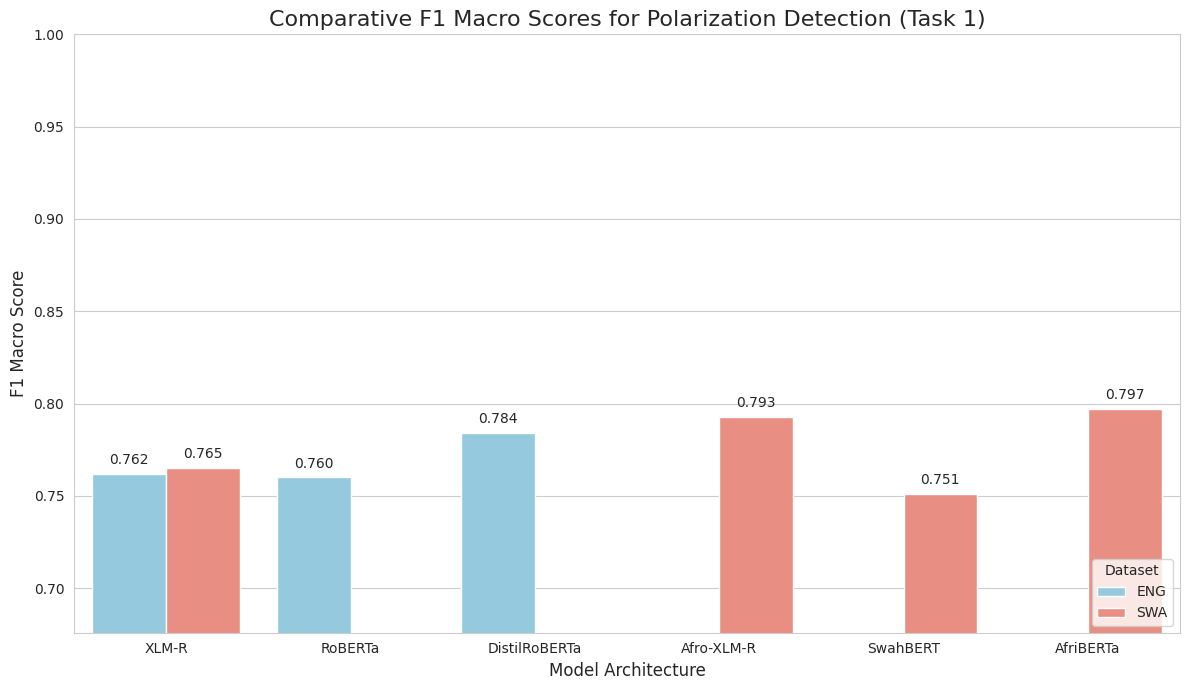

In [34]:
def plot_all_f1_scores(results_dict):
    """
    Plots a comparative bar chart of F1 Macro scores across all models and languages.
    """

    # Transform the results dictionary into a structured DataFrame
    data = []
    for key, f1_score in results_dict.items():
        model, lang = key.split('_')
        data.append({'Model': model, 'Language': lang.upper(), 'F1 Macro Score': f1_score})

    df_results = pd.DataFrame(data)

    # Set up the plot aesthetics
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 7))

    # Create the grouped bar plot
    ax = sns.barplot(
        x='Model',
        y='F1 Macro Score',
        hue='Language',
        data=df_results,
        palette={'ENG': 'skyblue', 'SWA': 'salmon'}
    )

    plt.title('Comparative F1 Macro Scores for Polarization Detection (Task 1)', fontsize=16)
    plt.xlabel('Model Architecture', fontsize=12)
    plt.ylabel('F1 Macro Score', fontsize=12)
    plt.ylim(df_results['F1 Macro Score'].min() * 0.9, 1.0)

    # Add data labels on top of each bar for precise reporting
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.3f}",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 10),
                    textcoords='offset points')

    plt.legend(title='Dataset', loc='lower right')
    plt.tight_layout()
    plt.show()

all_results = {
    "XLM-R_eng": 0.762,
    "XLM-R_swa": 0.765,
    "RoBERTa_eng": 0.760,
    "DistilRoBERTa_eng": 0.784,
    "Afro-XLM-R_swa": 0.793,
    "SwahBERT_swa": 0.751,
    "AfriBERTa_swa": 0.797
}

plot_all_f1_scores(all_results)

# Subtask 2: Polarization Type Classification
Multi-label classification to identify the target of polarization as one of the following categories: Gender/Sexual, Political, Religious, Racial/Ethnic, or Other.
For this task we will load the data for subtask 2.

In [25]:
data_eng_2 = pd.read_csv('subtask2/train/eng.csv')
test_eng_2 = pd.read_csv('subtask2/dev/eng.csv')
train_eng_2, val_eng_2 = train_test_split(data_eng_2, test_size=0.2, random_state=42)

data_swa_2 = pd.read_csv('subtask2/train/swa.csv')
test_swa_2 = pd.read_csv('subtask2/dev/swa.csv')
train_swa_2, val_swa_2 = train_test_split(data_swa_2, test_size=0.2, random_state=42)

print(f"Total samples for English dataset: {len(data_eng_2)}")
print(f"Train samples: {len(train_eng_2)}")
print(f"Validation samples: {len(val_eng_2)}")
print("**"*25)
print(f"Total samples for Swahili dataset: {len(data_swa_2)}")
print(f"Train samples: {len(train_swa_2)}")
print(f"Validation samples: {len(val_swa_2)}")

Total samples for English dataset: 3222
Train samples: 2577
Validation samples: 645
**************************************************
Total samples for Swahili dataset: 6991
Train samples: 5592
Validation samples: 1399


In [ ]:
train_eng_2.head()

,id,text,political,racial/ethnic,religious,gender/sexual,other
3000,eng_427cea503f2e3a2b4608d26fa87a55f0,The IDF needs some B52s.,0,0,0,0,0
366,eng_98eb4278a5fb9f249149a899b8f2c4e7,Fascinating life journey leads me to ANRAurora...,0,0,0,0,0
1965,eng_0d9c500e39edc99af8c61c45db8825a2,Lazy woke excuse to justify sjw practices,1,0,0,0,0
29,eng_69ebe50510087fb8c06cd12283a88ef8,5 takeaways on Republicans first impeachment h...,0,0,0,0,0
2689,eng_787ec0b4ddda46bbb5a0bf507a31d484,And yet Dems are supposed to be the breeders o...,1,0,0,0,0


In [ ]:
test_eng_2.head()

,id,text,political,racial/ethnic,religious,gender/sexual,other
0,eng_f66ca14d60851371f9720aaf4ccd9b58,God is with Ukraine and Zelensky,NaN,NaN,NaN,NaN,NaN
1,eng_3a489aa7fed9726aa8d3d4fe74c57efb,"4 Dems, 2 Republicans Luzerne County Council s...",NaN,NaN,NaN,NaN,NaN
2,eng_95770ff547ea5e48b0be00f385986483,Abuse Survivor Recounts Her Struggles at YWCA ...,NaN,NaN,NaN,NaN,NaN
3,eng_2048ae6f9aa261c48e6d777bcc5b38bf,"After Rwanda, another deportation camp disaster",NaN,NaN,NaN,NaN,NaN
4,eng_07781aa88e61e7c0a996abd1e5ea3a20,Another plea in Trump election interference probe,NaN,NaN,NaN,NaN,NaN


In [ ]:
train_swa_2.head()

,id,text,political,racial/ethnic,religious,gender/sexual,other
3875,swa_1e08a561fc1d7881fffb4822639b357f,kenya iuzw mtu apew share yake ama waturudishi...,0,0,0,0,0
1768,swa_b436d75df7d5cc4847f2c973740e49d0,bana rt mamzee especially hawa hapa twitter rt...,0,1,0,0,0
3250,swa_71b7ef26027e30d7f0e3025b5afb45ff,uliwaibia nani hao majembe la kutombwa pussy m...,0,0,0,0,0
6574,swa_fb121178c35ba35b1fafc735704824fa,Woi Museveni will kill us hio kamba hata ya ba...,0,1,0,0,1
2815,swa_1352a5d0c27ff8f79314abf4597a5046,mt hulipwa na supremacist mweupe kila wakati h...,0,0,0,0,0


In [ ]:
test_swa_2.head()

,id,text,political,racial/ethnic,religious,gender/sexual,other
0,swa_a5748df181277341143f7da4175add4a,walai iyo nyapati haijanifurahisha ata hawa wa...,NaN,NaN,NaN,NaN,NaN
1,swa_2df0d42f9b49ea2e4fb006b2e6604e6d,wajaluo maumbwa kabla utaje jina kubwa uhuru a...,NaN,NaN,NaN,NaN,NaN
2,swa_3718757514005767302b7220b08e409d,wakale wanafuatana na hawa wakikuyu mbna,NaN,NaN,NaN,NaN,NaN
3,swa_9fa3337a35cce723d60c06056d422330,wakikuyu wadeportiwe pia warudi kwao waruitania,NaN,NaN,NaN,NaN,NaN
4,swa_5c39ac8ef70345e9e3c21a47f8769bc0,wajaluo mnajionanga magenious sana,NaN,NaN,NaN,NaN,NaN


# Exploratory Data Analysis

## Label Frequency Distribution

In [36]:
LABEL_COLUMNS = ['political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']

In [ ]:
def plot_label_frequency(df: pd.DataFrame, language: str):
    """Generates a bar plot showing the frequency of each polarization type."""

    # Calculate the sum of 1s (True) for each label column
    label_counts = df[LABEL_COLUMNS].sum().sort_values(ascending=False)
    total_samples = len(df)

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")

    plt.title(f'Label Frequency Distribution: {language} Training Data', fontsize=14)
    plt.xlabel('Polarization Type', fontsize=12)
    plt.ylabel('Number of Samples Tagged', fontsize=12)

    # Add percentages above the bars
    for i, count in enumerate(label_counts.values):
        percentage = f'{count / total_samples * 100:.1f}%'
        ax.text(i, count + 20, f'{count}\n({percentage})', ha='center', va='bottom', fontsize=10)

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'label_frequency_{language}.pdf', dpi=300, bbox_inches='tight')
    plt.show()

/tmp/ipython-input-3603681311.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


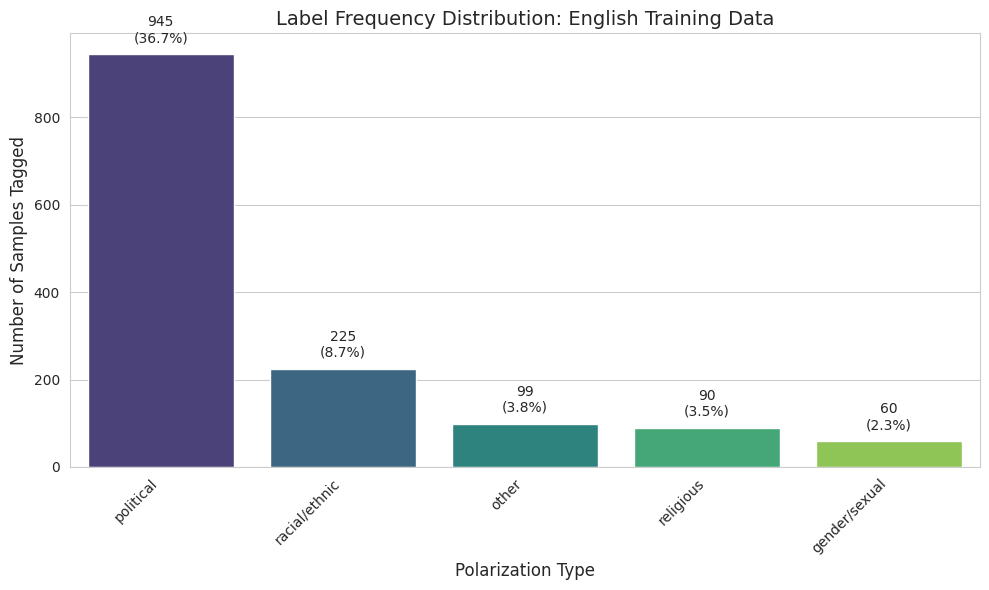

In [ ]:
plot_label_frequency(train_eng_2, "English")

/tmp/ipython-input-3603681311.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


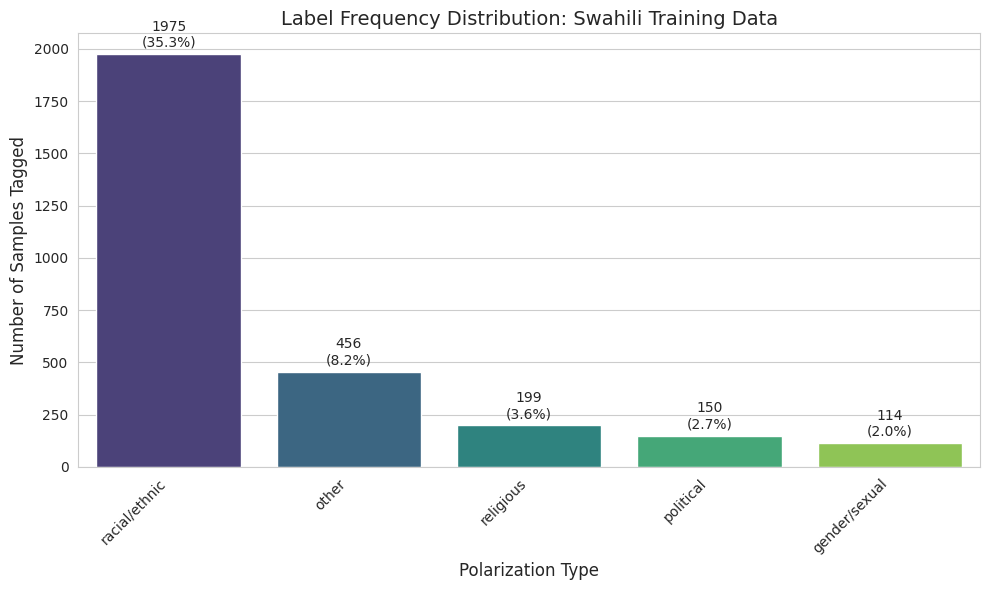

In [ ]:
plot_label_frequency(train_swa_2, "Swahili")

## Label Co-occurrence Heatmap

In [ ]:
def plot_co_occurrence_heatmap(df: pd.DataFrame, language: str):
    """Generates a heatmap showing the co-occurrence matrix of the polarization types."""

    # Calculate the Co-occurrence Matrix
    # We use the dot product of the label matrix with its transpose
    co_occurrence_matrix = df[LABEL_COLUMNS].T.dot(df[LABEL_COLUMNS])

    # Set up the plot aesthetics
    plt.figure(figsize=(9, 8))

    # Plot the heatmap
    sns.heatmap(
        co_occurrence_matrix,
        annot=True,              # Show the count in each cell
        fmt="d",                 # Format as integers
        cmap="Blues",            # Color map
        linewidths=0.5,          # Line width between cells
        linecolor='black',
        cbar_kws={'label': 'Number of Co-occurrences'} # Color bar title
    )

    plt.title(f'Label Co-occurrence Heatmap: {language} Training Data', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'label_co_occurrence_{language}.pdf', dpi=300, bbox_inches='tight')
    plt.show()

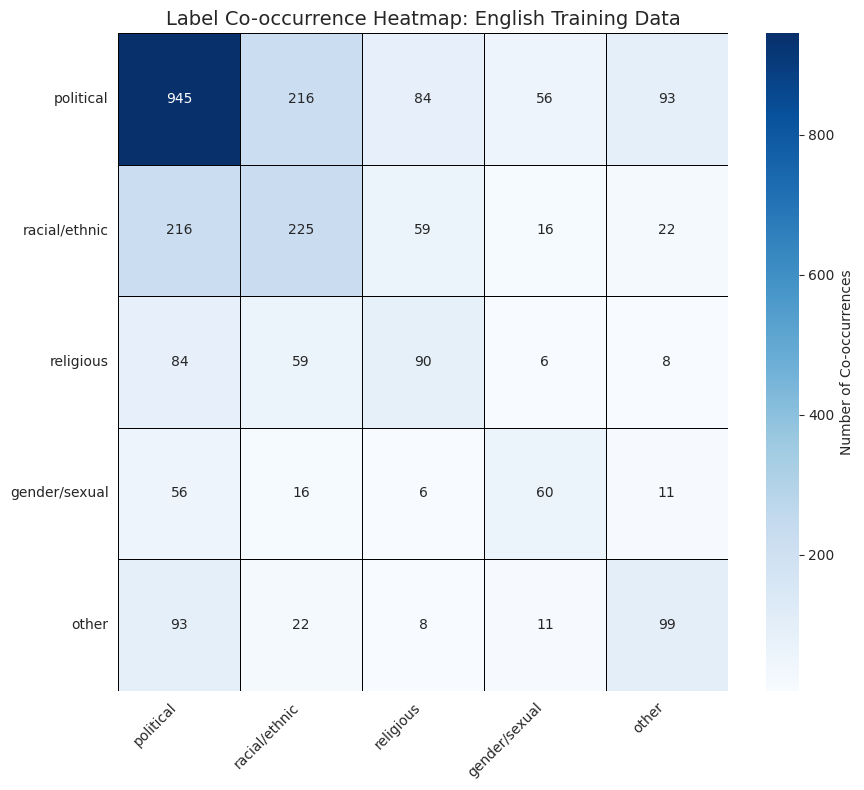

In [ ]:
plot_co_occurrence_heatmap(train_eng_2, "English")

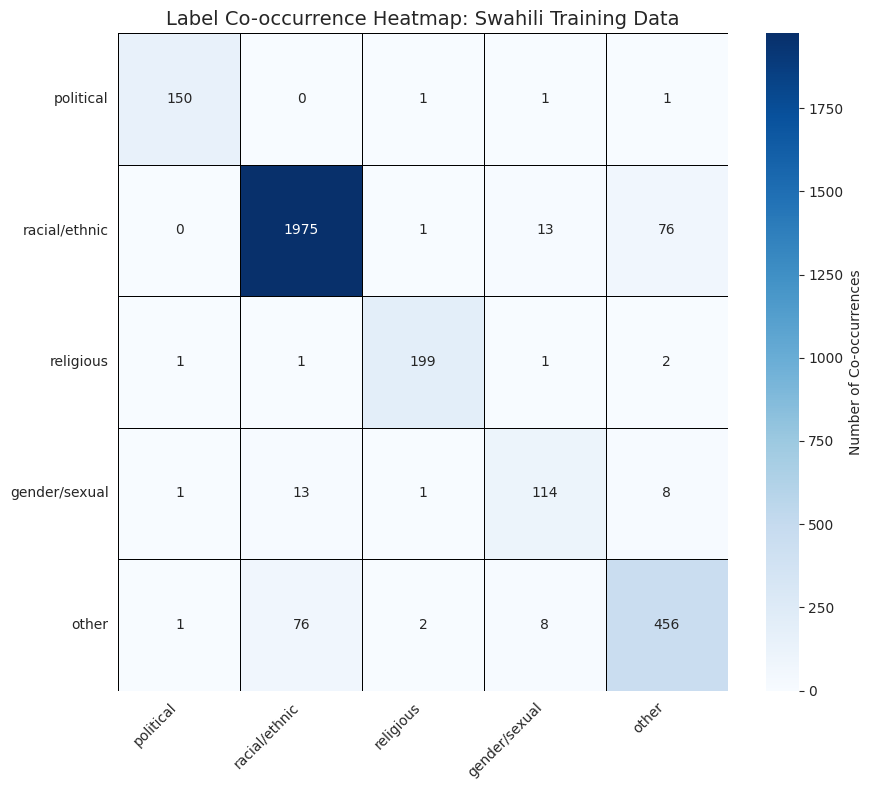

In [ ]:
plot_co_occurrence_heatmap(train_swa_2, "Swahili")

# Dataset

In [26]:
# Fix the dataset class by inheriting from torch.utils.data.Dataset
class PolarizationDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length # Store max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding=False, max_length=self.max_length, return_tensors='pt')

        # Ensure consistent tensor conversion for all items
        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        # CHANGE THIS LINE: Use torch.float instead of torch.long for multi-label classification
        item['labels'] = torch.tensor(label, dtype=torch.float)
        return item


In [34]:
for df in [train_eng_2, val_eng_2, train_swa_2, val_swa_2]:
    df['text_cleaned'] = df['text'].apply(clean_text_strategy_1)


test_eng_2['text_cleaned'] = test_eng_2['text'].apply(clean_text_strategy_1)
test_swa_2['text_cleaned'] = test_swa_2['text'].apply(clean_text_strategy_1)

## Label weights calculation

In [37]:
# Define the labels
def calculate_label_weights(df: pd.DataFrame, label_cols: List[str], device: torch.device):
    """
    Calculates inverse class frequency weights for use in the weighted loss function.
    """
    # Calculate the positive count for each label
    positive_counts = df[label_cols].sum(axis=0).values

    total_samples = len(df)

    weights = total_samples / (positive_counts + 1e-6)

    weights = weights / np.mean(weights)

    print("\nCalculated Label Weights")
    print(pd.Series(weights, index=label_cols).to_markdown())

    return torch.tensor(weights, dtype=torch.float).to(device)

# Execution
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

weights_eng = calculate_label_weights(train_eng_2, LABEL_COLUMNS, device)
weights_swa = calculate_label_weights(train_swa_2, LABEL_COLUMNS, device)


Calculated Label Weights
|               |        0 |
|:--------------|---------:|
| political     | 0.121965 |
| racial/ethnic | 0.512252 |
| religious     | 1.28063  |
| gender/sexual | 1.92094  |
| other         | 1.16421  |

Calculated Label Weights
|               |        0 |
|:--------------|---------:|
| political     | 1.43907  |
| racial/ethnic | 0.109297 |
| religious     | 1.08473  |
| gender/sexual | 1.89352  |
| other         | 0.47338  |


## Custom Weighted Multi-Label Loss Function

In [38]:
from torch.nn import BCEWithLogitsLoss

class CustomWeightedLossTrainer(torch.nn.Module):
    """
    A PyTorch module wrapper to apply the weighted BCEWithLogitsLoss.
    Used for multi-label classification to handle class imbalance.
    """
    def __init__(self, model, pos_weight):
        super().__init__()
        self.model = model
        # The pos_weight parameter takes the weights we calculated
        self.loss_fct = BCEWithLogitsLoss(pos_weight=pos_weight)

    def __call__(self, input_ids, attention_mask, labels=None):
        # Forward pass through the base model
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        loss = None
        if labels is not None:
            # Squeeze the logits if necessary (e.g., if batch size is 1)
            loss = self.loss_fct(logits, labels)

        return (loss, logits) if loss is not None else outputs

In [53]:
from transformers import EvalPrediction

def compute_metrics_multi_label(p: EvalPrediction, threshold: float = 0.5):
    """
    Computes the F1 Macro score for multi-label classification.
    """
    logits = p.predictions

    probs = 1.0 / (1.0 + np.exp(-logits))

    predictions = (probs > threshold).astype(int)

    labels = p.label_ids.astype(int)

    f1_macro = f1_score(labels, predictions, average="macro", zero_division=0)

    f1_per_class = f1_score(labels, predictions, average=None, zero_division=0)

    results = {
        "f1_macro": f1_macro,
        "f1_per_class": f1_per_class.tolist(),
    }
    return results

## Preparing the Data

In [46]:
# Define Models & MAX_LENGTH
MODEL_CONFIGS = {
    "XLM-R": "xlm-roberta-base",
    "DistilRoBERTa": "distilroberta-base",
    "AfriBERTa": "castorini/afriberta_large"
}

MAX_LENGTH = 64

# Function to Clean, Tokenize, and Load for a specific configuration ---
def setup_model_config(model_name: str, hf_model_path: str, lang_code: str):

    # Get the correct dataframes
    if lang_code == 'eng':
        train_df, val_df, test_df = train_eng_2, val_eng_2, test_eng_2
    else:
        train_df, val_df, test_df = train_swa_2, val_swa_2, test_swa_2

    # Get the calculated weights
    weights = weights_eng if lang_code == 'eng' else weights_swa

    # Load Tokenizer
    tokenizer = AutoTokenizer.from_pretrained(hf_model_path)
    print(f"\nLoaded Tokenizer: {model_name} for {lang_code.upper()}")

    # Create Datasets
    train_dataset = PolarizationDataset(
        texts=train_df['text_cleaned'].tolist(),
        labels=train_df[LABEL_COLUMNS].values.tolist(),
        tokenizer=tokenizer,
        max_length=MAX_LENGTH
    )
    val_dataset = PolarizationDataset(
        texts=val_df['text_cleaned'].tolist(),
        labels=val_df[LABEL_COLUMNS].values.tolist(),
        tokenizer=tokenizer,
        max_length=MAX_LENGTH
    )
    test_dataset = PolarizationDataset(
        texts=test_df['text_cleaned'].tolist(),
        labels=test_df[LABEL_COLUMNS].values.tolist(),
        tokenizer=tokenizer,
        max_length=MAX_LENGTH
    )

    # Load Model (Crucial: num_labels must equal the number of output classes)
    model = AutoModelForSequenceClassification.from_pretrained(
        hf_model_path,
        num_labels=len(LABEL_COLUMNS)
    )
    print(f"Loaded Model: {model_name} with {len(LABEL_COLUMNS)} output nodes.")

    # Wrap model with Custom Weighted Loss
    weighted_model = CustomWeightedLossTrainer(model, pos_weight=weights)
    print(f"Wrapped Model with Custom Weighted Loss (applied weights).")

    return tokenizer, weighted_model, train_dataset, val_dataset, test_dataset


# English Configurations
tokenizer_2_eng_xlm_r, model_eng_2_xlm_r, train_eng_2_xlm_r, val_eng_2_xlm_r, test_eng_2_xlm_r = setup_model_config("XLM-R", MODEL_CONFIGS["XLM-R"], 'eng')
tokenizer_2_eng_roberta, model_eng_2_roberta, train_eng_2_roberta, val_eng_2_roberta, test_eng_2_roberta = setup_model_config("DistilRoBERTa", MODEL_CONFIGS["DistilRoBERTa"], 'eng')

# Swahili Configurations
tokenizer_2_swa_xlm_r, model_swa_2_xlm_r, train_swa_2_xlm_r, val_swa_2_xlm_r, test_swa_2_xlm_r = setup_model_config("XLM-R", MODEL_CONFIGS["XLM-R"], 'swa')
tokenizer_2_swa_afro_xlmr, model_swa_2_afro_xlmr, train_swa_2_afro_xlmr, val_swa_2_afro_xlmr, test_swa_2_afro_xlmr = setup_model_config("AfriBERTa", MODEL_CONFIGS["AfriBERTa"], 'swa')

print("\nData preparation and custom loss setup complete.")

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Loaded Tokenizer: XLM-R for ENG
Loaded Model: XLM-R with 5 output nodes.
Wrapped Model with Custom Weighted Loss (applied weights).


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Loaded Tokenizer: DistilRoBERTa for ENG
Loaded Model: DistilRoBERTa with 5 output nodes.
Wrapped Model with Custom Weighted Loss (applied weights).


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Loaded Tokenizer: XLM-R for SWA
Loaded Model: XLM-R with 5 output nodes.
Wrapped Model with Custom Weighted Loss (applied weights).


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(



Loaded Tokenizer: AfriBERTa for SWA


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at castorini/afriberta_large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded Model: AfriBERTa with 5 output nodes.
Wrapped Model with Custom Weighted Loss (applied weights).

Data preparation and custom loss setup complete.


## Training Pipeline

In [61]:
def run_training_pipeline_t2(
    model_wrapper: torch.nn.Module, # The CustomWeightedLossTrainer wrapper
    tokenizer: AutoTokenizer,
    train_dataset: torch.utils.data.Dataset,
    val_dataset: torch.utils.data.Dataset,
    test_dataset: torch.utils.data.Dataset,
    test_df: pd.DataFrame,
    model_name_short: str,
    language_code: str
):
    """
    Sets up training for Task 2 Multi-Label Classification, using the weighted loss.
    """

    # Define Training Arguments
    output_dir = f"./results_task2/{model_name_short}_{language_code}"

    # Since we have severe imbalance, keeping a lower learning rate and moderate batch size is safer.
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=3,
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=False,
        logging_steps=50,
        disable_tqdm=False,
        remove_unused_columns=False,
        report_to="none"
    )

    # Initialize the Trainer
    trainer = Trainer(
        model=model_wrapper,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics_multi_label,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    )

    print(f"\n{'='*60}")
    print(f"Starting Training: - {model_name_short} ({language_code})")
    print(f"Using Weighted BCE Loss for Imbalance Mitigation.")
    print(f"{'='*60}")

    # Clear GPU memory
    gc.collect()
    torch.cuda.empty_cache()

    # Train and Evaluate
    trainer.train()

    print(f"\nEvaluating {model_name_short} on Validation Set...")
    eval_results = trainer.evaluate()

    print(f"Macro F1 score on validation set: {eval_results['epoch']:.4f}")

    # Generate predictions and submission file
    print(f"\nGenerating multi-label predictions on the test set for {language_code}...")

    raw_predictions = trainer.predict(test_dataset)

    logits = raw_predictions.predictions

    # Convert logits to binary predictions using a 0.5 threshold (logit 0)
    probabilities = 1.0 / (1.0 + np.exp(-logits))
    predictions = (probabilities > 0.5).astype(int) # This is the [0, 1, 0, 1, 0] vector output

    # Create submission file: one column for each label
    submission_df = pd.DataFrame(predictions, columns=LABEL_COLUMNS)
    submission_df.insert(0, 'id', test_df['id'].values)

    # Ensure the required columns are 0 or 1 integers
    for col in LABEL_COLUMNS:
        submission_df[col] = submission_df[col].astype(int)

    output_filename = f"pred_subtask2_{model_name_short}_{language_code}.csv"

    submission_df.to_csv(output_filename, index=False)

    print(f"\nSubmission file saved successfully as: {output_filename}")
    print("First 5 rows of the multi-label submission file:")
    print(submission_df.head().to_markdown(index=False))

    return eval_results['epoch']

## Execution of Pipelines

In [44]:
task2_results = {}

In [ ]:
# English with XLM-RoBERTa
f1 = run_training_pipeline_t2(model_wrapper=model_eng_2_xlm_r, tokenizer=tokenizer_2_eng_xlm_r,
                              train_dataset=train_eng_2_xlm_r, val_dataset=val_eng_2_xlm_r,
                              test_dataset=test_eng_2_xlm_r, test_df=test_eng_2,
                              model_name_short="XLM-R", language_code="eng")
task2_results["XLM-R_eng"] = f1


Starting Training: - XLM-R (eng)
Using Weighted BCE Loss for Imbalance Mitigation.


Epoch,Training Loss,Validation Loss
1,0.140500,No log
2,0.135400,No log


In [ ]:
# English with DistilRoBERTa
f1 = run_training_pipeline_t2(model_wrapper=model_eng_2_roberta, tokenizer=tokenizer_2_eng_roberta,
                              train_dataset=train_eng_2_roberta, val_dataset=val_eng_2_roberta,
                              test_dataset=test_eng_2_roberta, test_df=test_eng_2,
                              model_name_short="DistilRoBERTa", language_code="eng")
task2_results["DistilRoBERTa_eng"] = f1

In [ ]:
# Swahili with XLM-RoBERTa
f1 = run_training_pipeline_t2(model_wrapper=model_swa_2_xlm_r, tokenizer=tokenizer_2_swa_xlm_r,
                              train_dataset=train_swa_2_xlm_r, val_dataset=val_swa_2_xlm_r,
                              test_dataset=test_swa_2_xlm_r, test_df=test_swa_2,
                              model_name_short="XLM-R", language_code="swa")
task2_results["XLM-R_swa"] = f1

In [ ]:
# Swahili with AfriBERTa
f1 = run_training_pipeline_t2(model_wrapper=model_swa_2_afro_xlmr, tokenizer=tokenizer_2_swa_afro_xlmr,
                              train_dataset=train_swa_2_afro_xlmr, val_dataset=val_swa_2_afro_xlmr,
                              test_dataset=test_swa_2_afro_xlmr, test_df=test_swa_2,
                              model_name_short="AfriBERTa", language_code="swa")
task2_results["AfriBERTa_swa"] = f1

In [ ]:
# FINAL SUMMARY
print("\n" + "="*60)
print("TASK 2 TRAINING PIPELINES COMPLETED")
print("Validation F1 Macro Results (Multi-Label):")
print(pd.Series(task2_results).to_markdown(numalign="left", stralign="left"))
print("="*60)

## A visual analysis

In [ ]:
def plot_all_f1_scores_t2(results_dict: Dict[str, float]):
    """
    Plots a comparative bar chart of F1 Macro scores for subtask 2 (Multi-Label Classification)
    across all models and languages.

    Args:
        results_dict: Dictionary containing F1 Macro scores
    """
    data = []
    for key, f1_score in results_dict.items():
        model, lang = key.split('_')
        data.append({'Model': model, 'Language': lang.upper(), 'F1 Macro Score': f1_score})

    df_results = pd.DataFrame(data)

    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))

    ax = sns.barplot(
        x='Model',
        y='F1 Macro Score',
        hue='Language',
        data=df_results,
        palette={'ENG': 'skyblue', 'SWA': 'salmon'}
    )

    plt.title('Comparative F1 Macro Scores for Polarization Type Classification (Task 2)', fontsize=14)
    plt.xlabel('Model Architecture', fontsize=12)
    plt.ylabel('F1 Macro Score (Multi-Label)', fontsize=12)

    y_min = df_results['F1 Macro Score'].min() * 0.95
    plt.ylim(y_min, 1.0)

    for p in ax.patches:
        ax.annotate(f"{p.get_height():.3f}",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 10),
                    textcoords='offset points',
                    fontsize=9)

    plt.legend(title='Dataset', loc='upper left')
    plt.tight_layout()
    plt.savefig('task2_f1_macro_comparison.png')
    plt.close()

plot_all_f1_scores_t2(task2_results)

# Subtask 3: Manifestation Identification
Multi-label classification to classify how polarization is expressed, with multiple possible labels including Vilification, Extreme Language, Stereotype, Invalidation, Lack of Empathy, and Dehumanization.



In [ ]:
train = pd.read_csv('subtask3/train/eng.csv')
val = pd.read_csv('subtask3/train/eng.csv')

train.head()

In [ ]:
# Fix the dataset class by inheriting from torch.utils.data.Dataset
class PolarizationDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length # Store max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding=False, max_length=self.max_length, return_tensors='pt')

        # Ensure consistent tensor conversion for all items
        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        # CHANGE THIS LINE: Use torch.float instead of torch.long for multi-label classification
        item['labels'] = torch.tensor(label, dtype=torch.float)
        return item

In [ ]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Create train and Test dataset for multilabel
train_dataset = PolarizationDataset(train['text'].tolist(), train[['vilification','extreme_language','stereotype','invalidation','lack_of_empathy','dehumanization']].values.tolist(), tokenizer)
val_dataset = PolarizationDataset(val['text'].tolist(), val[['vilification','extreme_language','stereotype','invalidation','lack_of_empathy','dehumanization']].values.tolist(), tokenizer)

In [ ]:
# Load the model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6, problem_type="multi_label_classification") # use 6 labels

In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir=f"./",
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="no",
    logging_steps=100,
    disable_tqdm=False
)

# Define metrics function for multi-label classification
def compute_metrics_multilabel(p):
    # Sigmoid the predictions to get probabilities
    probs = torch.sigmoid(torch.from_numpy(p.predictions))
    # Convert probabilities to predicted labels (0 or 1)
    preds = (probs > 0.5).int().numpy()
    # Compute macro F1 score
    return {'f1_macro': f1_score(p.label_ids, preds, average='macro')}

In [ ]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics_multilabel,  # Use the new metrics function
    data_collator=DataCollatorWithPadding(tokenizer)
)

# Train the model
trainer.train()

# Evaluate the model on the validation set
eval_results = trainer.evaluate()
print(f"Macro F1 score on validation set for Subtask 3: {eval_results['eval_f1_macro']}")